In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('merged.csv')

In [3]:
df = df.drop(columns='Unnamed: 0')

In [4]:
import pandas as pd
df['scheduled'] = pd.to_datetime(df['scheduled'])
df['actual'] = pd.to_datetime(df['actual'])
df['No. of late arrivals'] = (df['actual'] > df['scheduled'])
route_ranking = df.groupby('route_id')['No. of late arrivals'].mean().reset_index()
route_ranking = route_ranking.sort_values(by='No. of late arrivals')


In [5]:
df['time_point_order'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [6]:
route_ranking =route_ranking.reset_index()

In [7]:
route_ranking = route_ranking.drop(columns='index')

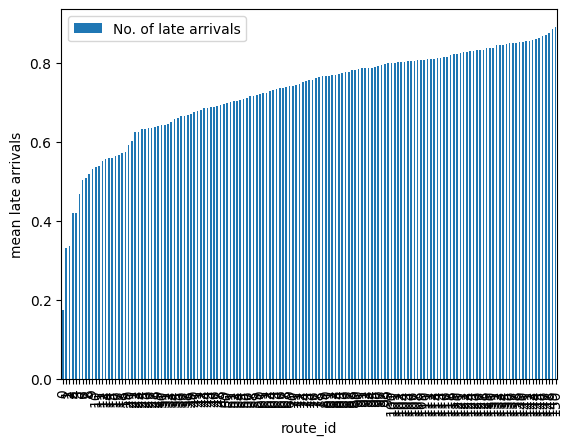

In [11]:
df_sorted = route_ranking

ax = df_sorted.plot(kind='bar')  # Use your actual column names for 'x' and 'y'

# Label the x and y axes
ax.set_xlabel("route_id")
ax.set_ylabel("mean late arrivals")

import  matplotlib.pyplot as plt
# Show the plot
plt.show()


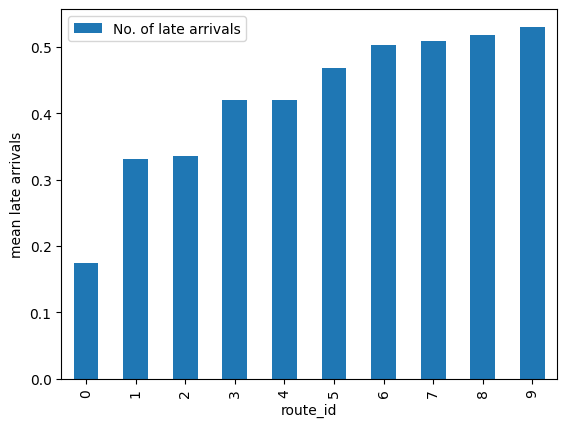

In [12]:
df_sorted = route_ranking[:10]

ax = df_sorted.plot(kind='bar')  # Use your actual column names for 'x' and 'y'

# Label the x and y axes
ax.set_xlabel("route_id")
ax.set_ylabel("mean late arrivals")

import  matplotlib.pyplot as plt
# Show the plot
plt.show()


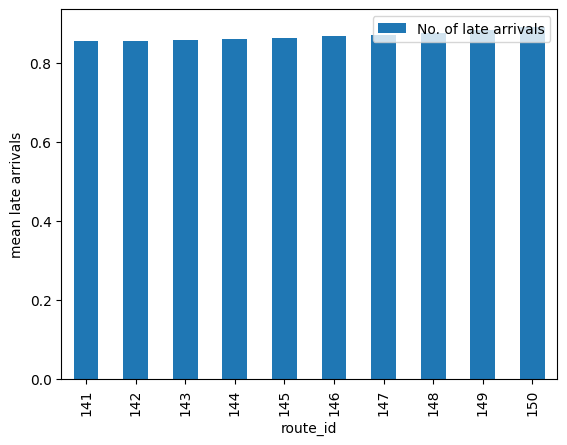

In [13]:
df_sorted = route_ranking[-10:]

ax = df_sorted.plot(kind='bar')  # Use your actual column names for 'x' and 'y'

# Label the x and y axes
ax.set_xlabel("route_id")
ax.set_ylabel("mean late arrivals")

import  matplotlib.pyplot as plt
# Show the plot
plt.show()
